In [1]:
# TODO: automate with nice data configs of selected variables etc.
# TODO: logging functions
# TODO: NNs!

%load_ext autoreload
%autoreload 2

# file handling
from pathlib import Path
import pickle
import warnings

# spatial
import xarray as xa
import geopandas as gpd
import cartopy.crs as ccrs

# general
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

# processing
from dask.distributed import get_client, Client, LocalCluster
import dask
import joblib

# ml
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as sklmetrics
from sklearn import svm, datasets
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

# custom
from coralshift.dataloading import config, get_data
from coralshift import functions_creche
from coralshift.processing import spatial_data
from coralshift.machine_learning import baselines
from coralshift.plotting import spatial_plots
from coralshift.utils import utils

# set data folder path
data_fp = config.data_folder

### Loading in specific resolution .nc file with RF variables for particular area

In [3]:
high_res_ds_fp = Path("/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1_latlon/rf_all_vars_0-004_lats_-32-0_lons_130-170.nc")
high_res_ds = xa.open_dataset(high_res_ds_fp)
# high_res_ds = xa.open_dataset("data/temp_rf_lats_-32-0_lons_130-170_ds.nc")
high_res_ds.latitude.values[:5] # used to check latitude resolution

array([-32.        , -31.99583333, -31.99166667, -31.9875    ,
       -31.98333333])

### Split high-res file into smaller areas

In [4]:
resolution_lat, resolution_lon = 0.01, 0.01

# # split files from single high res file of all vars into separate files
# TODO: make sure this overwrites/or doesn't existing individual files
# split_dataset_and_save(
#     high_res_ds_fp, divisor=8, output_dir_name=high_res_ds_fp.parent)

# # This is used since it falls over at high resolutions. Replaced with the splitting-processing-rejoining method
# ((X_train, y_train), (X_test, y_test)), dfs_list = get_data.get_data("rf", resolution_lat, resolution_lon)

In [4]:
warnings.filterwarnings(action='ignore', category=RuntimeWarning, message='Degrees of freedom <= 0 for slice.')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, message='All-NaN slice encountered')

# select number of subfiles to load
num_files = -1
# TODO: make generic
nc_fps = list(Path("/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1_0-01_latlon_64_split_datasets").glob("rf*.nc"))[:num_files]

train_Xs, train_ys = [], []
for i, fp in tqdm(enumerate(nc_fps), total=len(nc_fps)):
    ds = xa.open_dataset(fp)
    # convert xarray to ml-ready pandas df
    X, y = functions_creche.ds_to_ml_ready(ds, remove_rows=True)
    train_Xs.append(X)
    train_ys.append(y)

# train_Xs = pd.concat(train_Xs, axis=0)
# train_ys = pd.concat(train_ys, axis=0)

# TODO: proper pipeline splitting of train and test sets. Perhaps like this but hopefully better
# TODO: function which takes area bounds and visualises on map

# test_Xs, test_ys = [], []
# for i, fp in enumerate(test_nc_fps):
#     ds = xa.open_dataset(fp)
#     X, y = ds_to_ml_ready(ds, remove_rows=True)
#     test_Xs.append(X)
#     test_ys.append(y)

# test_Xs = pd.concat(test_Xs, axis=0)
# test_ys = pd.concat(test_ys, axis=0)

100%|██████████| 63/63 [14:44<00:00, 14.04s/it]


In [6]:
X_df = pd.concat(train_Xs, axis=0)
y_df = pd.concat(train_ys, axis=0)

X = X_df.to_numpy()
y = y_df.to_numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X_df, y_df, test_size=0.2, random_state=42)

X shape: (706840, 282)
y shape: (706840,)


In [7]:
masked_X = X_df.to_xarray().sortby("longitude").sortby("latitude")

# sorted = out["predictions"].sortby("longitude").sortby("latitude")


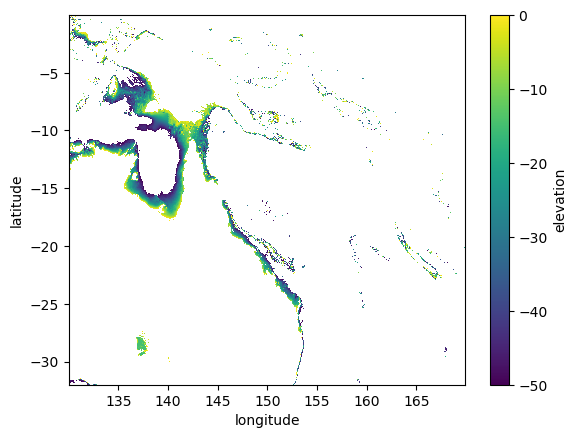

In [8]:
masked_X["elevation"].isel(latitude=slice(0,-1), longitude=slice(0,-1)).plot()

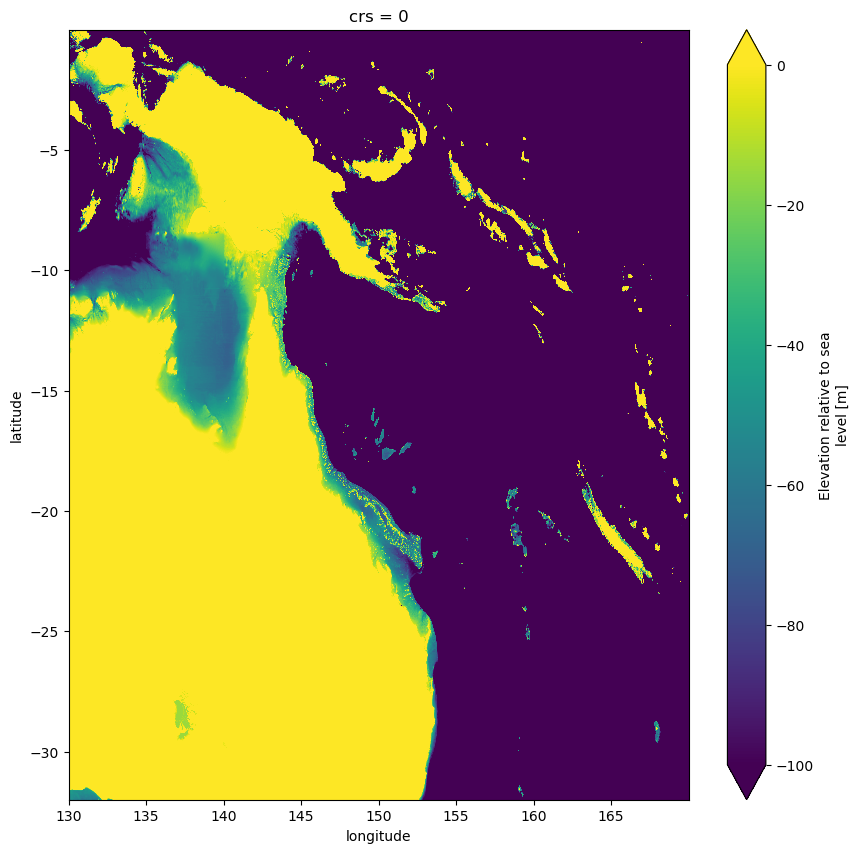

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

high_res_ds["elevation"].isel(latitude=slice(0,-1), longitude=slice(0,-1)).plot(ax=ax, vmin=-100, vmax=0)

In [10]:
# plot gt against depth

high_res_ds["unep_coral_presence"]

<xarray.DataArray 'unep_coral_presence' (latitude: 7680, longitude: 9600)>
[73728000 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -32.0 -32.0 -31.99 ... -0.008333 -0.004167
  * longitude  (longitude) float64 130.0 130.0 130.0 130.0 ... 170.0 170.0 170.0
    crs        int64 ...
Attributes:
    crs:      EPSG:4326

(-4000.0, -2000.0)

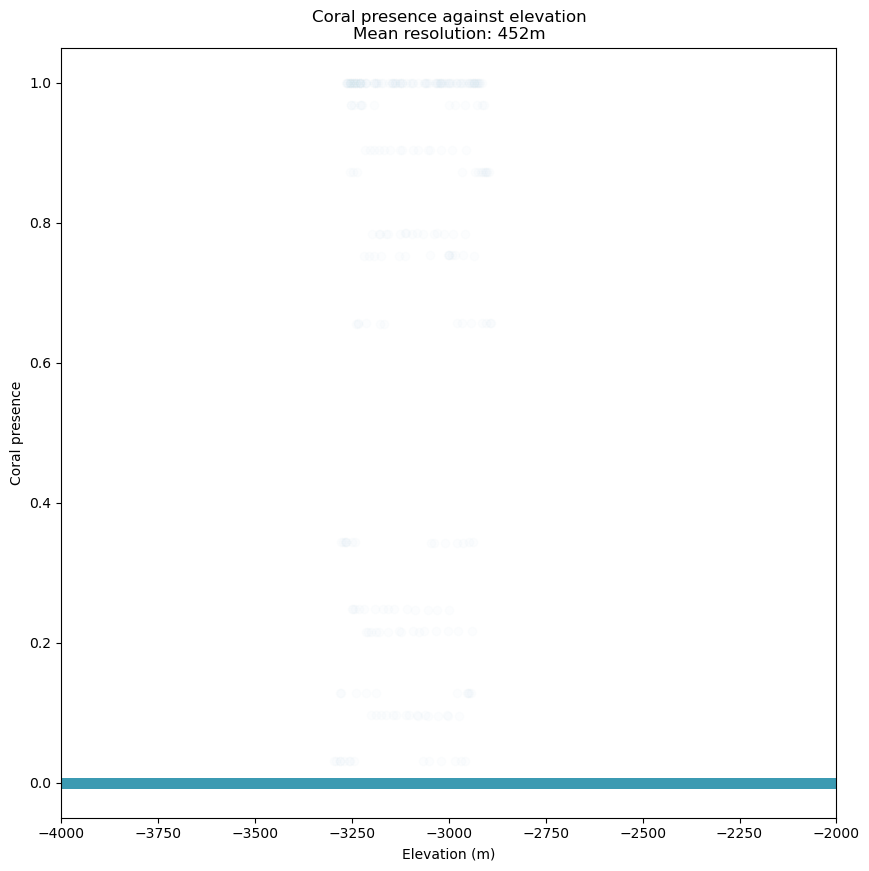

In [11]:
gt = high_res_ds["unep_coral_presence"].values.flatten()
elev = high_res_ds["elevation"].values.flatten()

mean_res = spatial_data.degrees_to_distances(spatial_data.calculate_spatial_resolution(high_res_ds)[1])[2]

f, ax = plt.subplots(figsize=(10,10))
ax.scatter(elev, gt, alpha=0.01, color="#3B9AB2")
ax.set_xlabel("Elevation (m)");
ax.set_ylabel("Coral presence");
ax.set_title("Coral presence against elevation\nMean resolution: {:.0f}m".format(mean_res));
ax.set_xlim([-4000,-2000])

In [6]:
def coral_presence_within_depths(ds: xa.Dataset, depth_range: list):
    """Returns a dataframe of coral specific to a range of elevations"""
    depths_within_range = ds.where((ds["elevation"] < max(depth_range)) & (ds["elevation"] > min(depth_range)))
    coral_depths_within_range = depths_within_range.where(depths_within_range["unep_coral_presence"] > 0)

    print("total coral presence within depths:", coral_depths_within_range["unep_coral_presence"].sum().values)
    return coral_depths_within_range

deep_cutoff = [-3500, -2750]
deep_coral_depths = coral_presence_within_depths(high_res_ds, deep_cutoff)
deep_coral_lats = deep_coral_depths["unep_coral_presence"].sum(dim="latitude")
deep_coral_lons = deep_coral_depths["unep_coral_presence"].sum(dim="longitude")

total coral presence within depths: 168.01568209215333


In [7]:
land_cutoff = [0, 500]
land_coral_depths = coral_presence_within_depths(high_res_ds, land_cutoff)
land_coral_lats = land_coral_depths["unep_coral_presence"].sum(dim="latitude")
land_coral_lons = land_coral_depths["unep_coral_presence"].sum(dim="longitude")

total coral presence within depths: 78498.910032798


In [17]:
zoom_anomaly = True
deep_anomaly_lats = [-15,-14.85]
deep_anomaly_lons = [159.4,159.55]


def visualise_coral_depths(ds, ds_depths_coral, depths_coral_lats, depths_coral_lons, anomaly_lats=None, anomaly_lons=None):
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(2, 2)
    # assign map axes
    ax_coral_map = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
    ax_depth_map = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree())
    # assign bar chart axes
    ax_lat_bar = fig.add_subplot(gs[1,0])
    ax_lon_bar = fig.add_subplot(gs[0,1])
    # format axes
    ax_lat_bar.set_yscale("log")
    ax_lat_bar.invert_yaxis()
    ax_lon_bar.set_xscale("log")

    if anomaly_lats and anomaly_lons:
        spatial_plots.plot_spatial(ds_depths_coral["unep_coral_presence"].sel(
            longitude=slice(min(anomaly_lons), max(anomaly_lons)), latitude=slice(min(anomaly_lats), max(anomaly_lats))),
            cbar = False, fax=(fig,ax_coral_map), labels=["l","t"], label_style_dict={"fontsize": 8}, 
            )

        spatial_plots.plot_spatial(ds["elevation"].sel(
            longitude=slice(min(anomaly_lons), max(anomaly_lons)), latitude=slice(min(anomaly_lats), max(anomaly_lats))),
            cbar = True, fax=(fig,ax_depth_map), labels=["b","l"], label_style_dict={"fontsize": 8}, 
        cbar_pad=-0.05)


        lim_depths_coral_lats = depths_coral_lats.sel(longitude=slice(min(anomaly_lons), max(anomaly_lons)))
        lim_depths_coral_lons = depths_coral_lons.sel(latitude=slice(min(anomaly_lats), max(anomaly_lats)))

        ax_lat_bar.bar(lim_depths_coral_lats.longitude, width=spatial_data.calculate_coord_resolution(depths_coral_lats, "longitude"),
            height=lim_depths_coral_lats.values, 
            color="#d83c04")
        ax_lon_bar.barh(lim_depths_coral_lons.latitude, width=lim_depths_coral_lons.values, 
            height=spatial_data.calculate_coord_resolution(depths_coral_lons, "latitude"),
            color="#d83c04"
            )

        ax_lat_bar.set_xlim([min(anomaly_lons), max(anomaly_lons)])
        ax_lon_bar.set_ylim([min(anomaly_lats), max(anomaly_lats)])
        # set relevant grid lines


    else:
        spatial_plots.plot_spatial(ds_depths_coral["unep_coral_presence"],
            cbar = False, fax=(fig,ax_coral_map), labels=["l","t"], label_style_dict={"fontsize": 8})
        spatial_plots.plot_spatial(ds["elevation"],
            cbar = False, fax=(fig,ax_depth_map), labels=["b","l"], label_style_dict={"fontsize": 8})

        ax_lat_bar.bar(depths_coral_lats.longitude, width=spatial_data.calculate_coord_resolution(depths_coral_lats, "longitude"),
            height=depths_coral_lats.values, 
            color="#d83c04")
        ax_lon_bar.barh(depths_coral_lons.latitude, width=depths_coral_lons.values, 
            height=spatial_data.calculate_coord_resolution(depths_coral_lons, "latitude"),
            color="#d83c04"
            )
    ax_lon_bar.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax_lat_bar.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

def mask_visualise_coral_depths(ds: xa.Dataset, depth_range: list, anomaly_lats=None, anomaly_lons=None):
    """Visualises coral presence at a range of depths"""

    # masking corals within depths
    coral_depths_within_range = coral_presence_within_depths(ds, depth_range)
    # calculating coral presence grouped by latitude and longitude
    coral_depth_lats = coral_depths_within_range["unep_coral_presence"].sum(dim="latitude")
    coral_depth_lons = coral_depths_within_range["unep_coral_presence"].sum(dim="longitude")

    visualise_coral_depths(ds, ds_depths_coral, depths_coral_lats, depths_coral_lons, anomaly_lats=anonaly_lats, anomaly_lons=anonaly_lons)

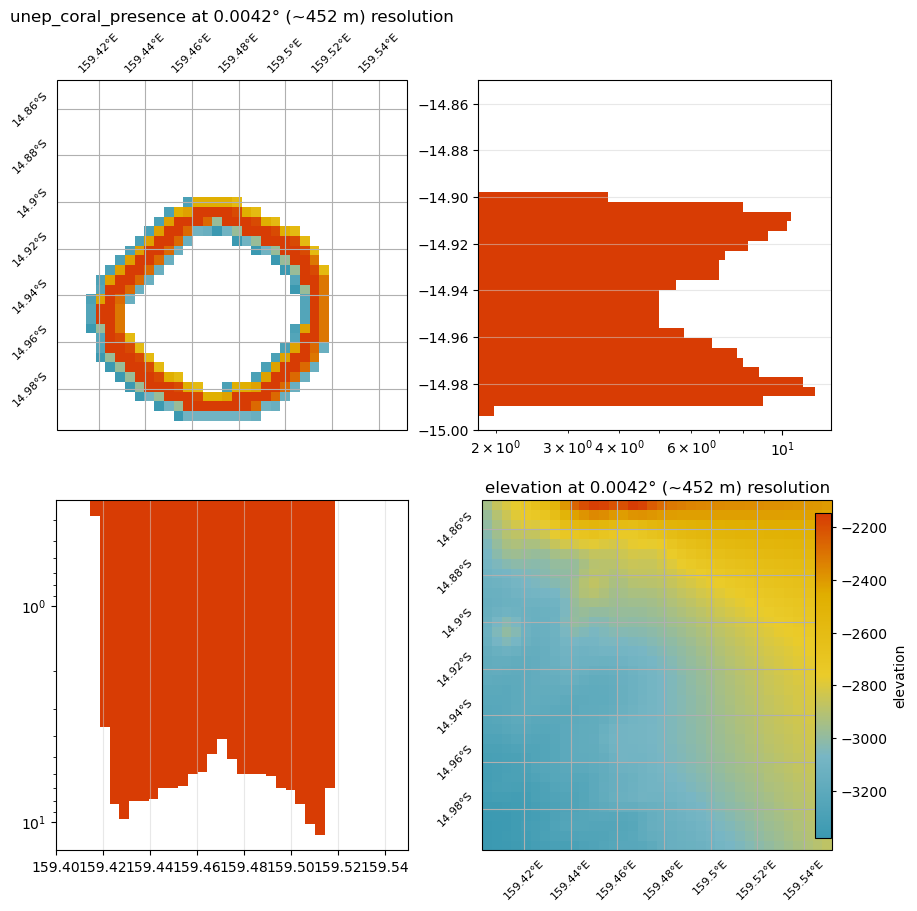

In [24]:
deep_anomaly_lats = [-15,-14.85]
deep_anomaly_lons = [159.4,159.55]
visualise_coral_depths(high_res_ds, deep_coral_depths, deep_coral_lats, deep_coral_lons
, anomaly_lats=deep_anomaly_lats, anomaly_lons=deep_anomaly_lons
)

In [16]:
np.nanmax(land_coral_depths["elevation"].values)

484.99999999103693

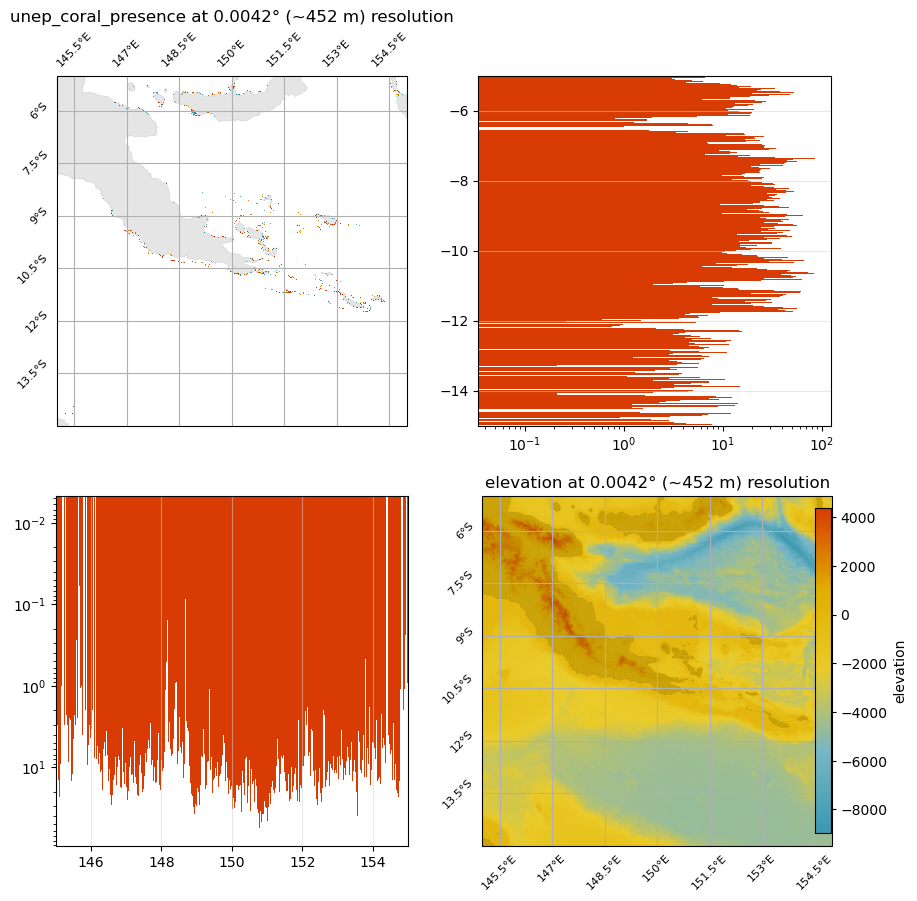

In [19]:
land_coral_anomaly_lats = [-15,-5]
land_coral_anomaly_lons = [145,155]
visualise_coral_depths(high_res_ds, land_coral_depths, land_coral_lats, land_coral_lons, anomaly_lats=land_coral_anomaly_lats, anomaly_lons=land_coral_anomaly_lons)

(<Figure size 1000x1000 with 4 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.0042° (~452 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f624eadbc50>)

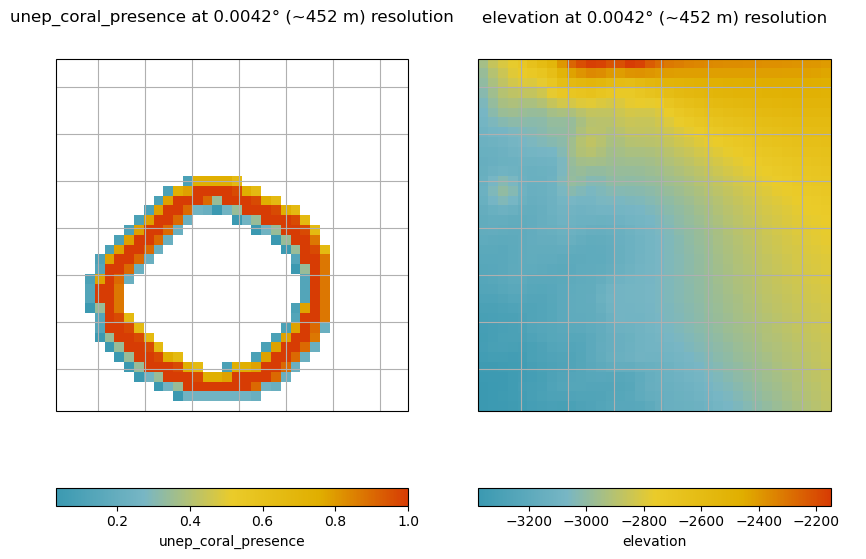

In [51]:
f, ax = plt.subplots(ncols=2, figsize=(10,10), subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(ds_depths_coral["unep_coral_presence"].sel(
    longitude=slice(min(anomaly_lons), max(anomaly_lons)), latitude=slice(min(anomaly_lats), max(anomaly_lats))), 
    cbar=True, fax=(f,ax[0]), cbar_orientation="horizontal")
spatial_plots.plot_spatial(high_res_ds["elevation"].sel(
    longitude=slice(min(anomaly_lons), max(anomaly_lons)), latitude=slice(min(anomaly_lats), max(anomaly_lats))),
    cbar=True, fax=(f,ax[1]), cbar_orientation="horizontal")

In [14]:
depths_coral_lons.latitude

<xarray.DataArray 'latitude' (latitude: 7680)>
array([-3.200000e+01, -3.199583e+01, -3.199167e+01, ..., -1.250000e-02,
       -8.333333e-03, -4.166667e-03])
Coordinates:
  * latitude  (latitude) float64 -32.0 -32.0 -31.99 ... -0.008333 -0.004167
    crs       int64 0

In [23]:
gt = high_res_ds["unep_coral_presence"].values.flatten()
elev = high_res_ds["elevation"].values.flatten()

mean_res = spatial_data.degrees_to_distances(spatial_data.calculate_spatial_resolution(high_res_ds)[1])[2]

plt.scatter(elev[::4], gt[::4], alpha=0.01, color="#3B9AB2")
plt.xlabel("Elevation (m)");
plt.ylabel("Coral presence");
plt.title("Coral presence against elevation\nMean resolution: {:.0f}m".format(mean_res));

In [29]:
spatial_data.calculate_spatial_resolution(high_res_ds)

(0.010000000000001563, 0.009999999999990905)

In [33]:
spatial_data.degrees_to_distances(spatial_data.calculate_spatial_resolution(high_res_ds)[1])

latitudinal distance, longitudinal distance, mean distance


(1111.950802334199, 1057.528056229708, 1084.7394292819536)

In [22]:
gt

array([0., 0., 0., ..., 0., 0., 0.])

# Handling .db files (bleaching data)

Goal: single dataframe with datetime object, location, bleaching events, sample_id.
Could additionally include turbidity, exposure, distance_to_shore, cyclone_frequency.
Achieved!

In [19]:
import sqlite3

In [18]:
cnx = sqlite3.connect("/maps/rt582/coralshift/data/Global_Coral_Bleaching_Database_SQLite_11_24_21.db")
df_sites = pd.read_sql_query("SELECT * FROM Site_Info_tbl", cnx)
df_bleaching = pd.read_sql_query("SELECT * FROM Bleaching_tbl", cnx)
df_event = pd.read_sql_query("SELECT * FROM Sample_Event_tbl", cnx)
df_cover = pd.read_sql_query("SELECT * FROM Cover_tbl", cnx)
df_env = pd.read_sql_query("SELECT * FROM Environmental_tbl", cnx)

# wrap up sqlite3 connection
cnx.commit()
cnx.close()

In [73]:
# join df_cover and df_event on sample_id
df_cover_event = df_cover.join(df_event.set_index("Sample_ID"), on="Sample_ID", how="left", lsuffix="_cover", rsuffix="_event")
# join df_cover_event and df_bleaching on sample_id
df_cover_event_bleaching = df_cover_event.join(df_bleaching.set_index("Sample_ID"), on="Sample_ID", how="left", lsuffix="_cover_event", rsuffix="_bleaching")
# df_cover_event
# join df_cover_event_bleaching and df_sites on site_id
df_all = df_cover_event_bleaching.join(df_sites.set_index("Site_ID"), on="Site_ID", how="left", lsuffix="_cover_event_bleaching", rsuffix="_sites")
# create new datetime objects from columns
df_all["Date"] = pd.to_datetime(df_all["Date_Year"].astype(int).astype(str) + "-" + df_all["Date_Month"].astype(int).astype(str) + "-" + df_all["Date_Day"].astype(int).astype(str))
df_all["Fractional_Date"] = df_all["Date"].dt.year + (df_all["Date"].dt.dayofyear / 365)
df_all.columns

Index(['Cover_ID', 'Sample_ID', 'Percent_Hard_Coral', 'Percent_Macroalgae',
       'Substrate_Type', 'S1_cover_event', 'S2_cover_event', 'S3_cover_event',
       'S4_cover_event', 'Comments_cover', 'TRIAL495', 'Site_ID', 'Reef_ID',
       'Date_Day', 'Date_Month', 'Date_Year', 'Depth_m', 'Quadrat_No',
       'Comments_event', 'TRIAL528', 'Bleaching_ID', 'Bleaching_Level',
       'S1_bleaching', 'S2_bleaching', 'S3_bleaching', 'S4_bleaching',
       'Percent_Bleaching_Old_Method', 'Severity_Code', 'Percent_Bleached',
       'Number__Bleached_Colonies', 'bleach_intensity',
       'Bleaching_Prevalence_Score', 'TRIAL485', 'Data_Source',
       'Latitude_Degrees', 'Longitude_Degrees', 'Ocean_Name', 'Realm_Name',
       'Ecoregion_Name', 'Country_Name', 'State_Island_Province_Name',
       'City_Town_Name', 'City_Town_Name_2', 'City_Town_Name_3',
       'City_Town_Name_4', 'Site_Name', 'Distance_to_Shore', 'Exposure',
       'Turbidity', 'Cyclone_Frequency', 'Comments', 'TRIAL534', 'Date',


In [89]:
df_all["Severity_Code"].unique()

array([nan])

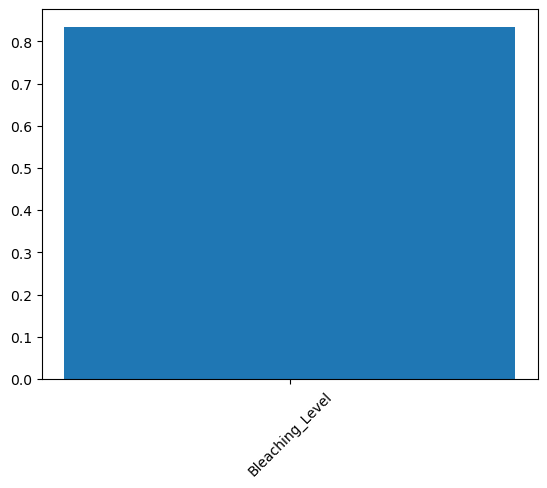

In [112]:
# plot a bar chart of frequency of values for specified columns
col_sel = ["Bleaching_Level", 
# "Percent_Bleaching_Old_Method", "Severity_Code", "Percent_Bleached", "Number__Bleached_Colonies", "bleach_intensity", "Bleaching_Prevalence_Score"
]

# f, a = plt.subplots(figsize=(10,5))
# plot number of unique values, handling values which are NaN
for col in col_sel:
    # count number of entries which aren't nans
    not_nans = df_all[col].notna().sum()
    # normalise
    not_nan_ratio = not_nans / len(df_all[col])
    # plot
    plt.bar(col, not_nan_ratio, label=col)
    plt.xticks(rotation=45)

    # unique_vals = df_all[col].nunique()
    # # print(vals)
    # if unique_vals != 0:
    #     vals = df_all[col].value_counts()
    #     vals.plot(kind="bar", label=col)
    # if np.nan in vals.index:
    #     vals = vals.drop(np.nan)
    #     vals = vals.append(pd.Series([df_all[col].isna().sum()], index=["NaN"]))
    # vals.plot(kind="bar", ax=a, label=col)


In [113]:
not_nan_ratio

0.8341912455382303

/tmp/ipykernel_1525610/1773794463.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


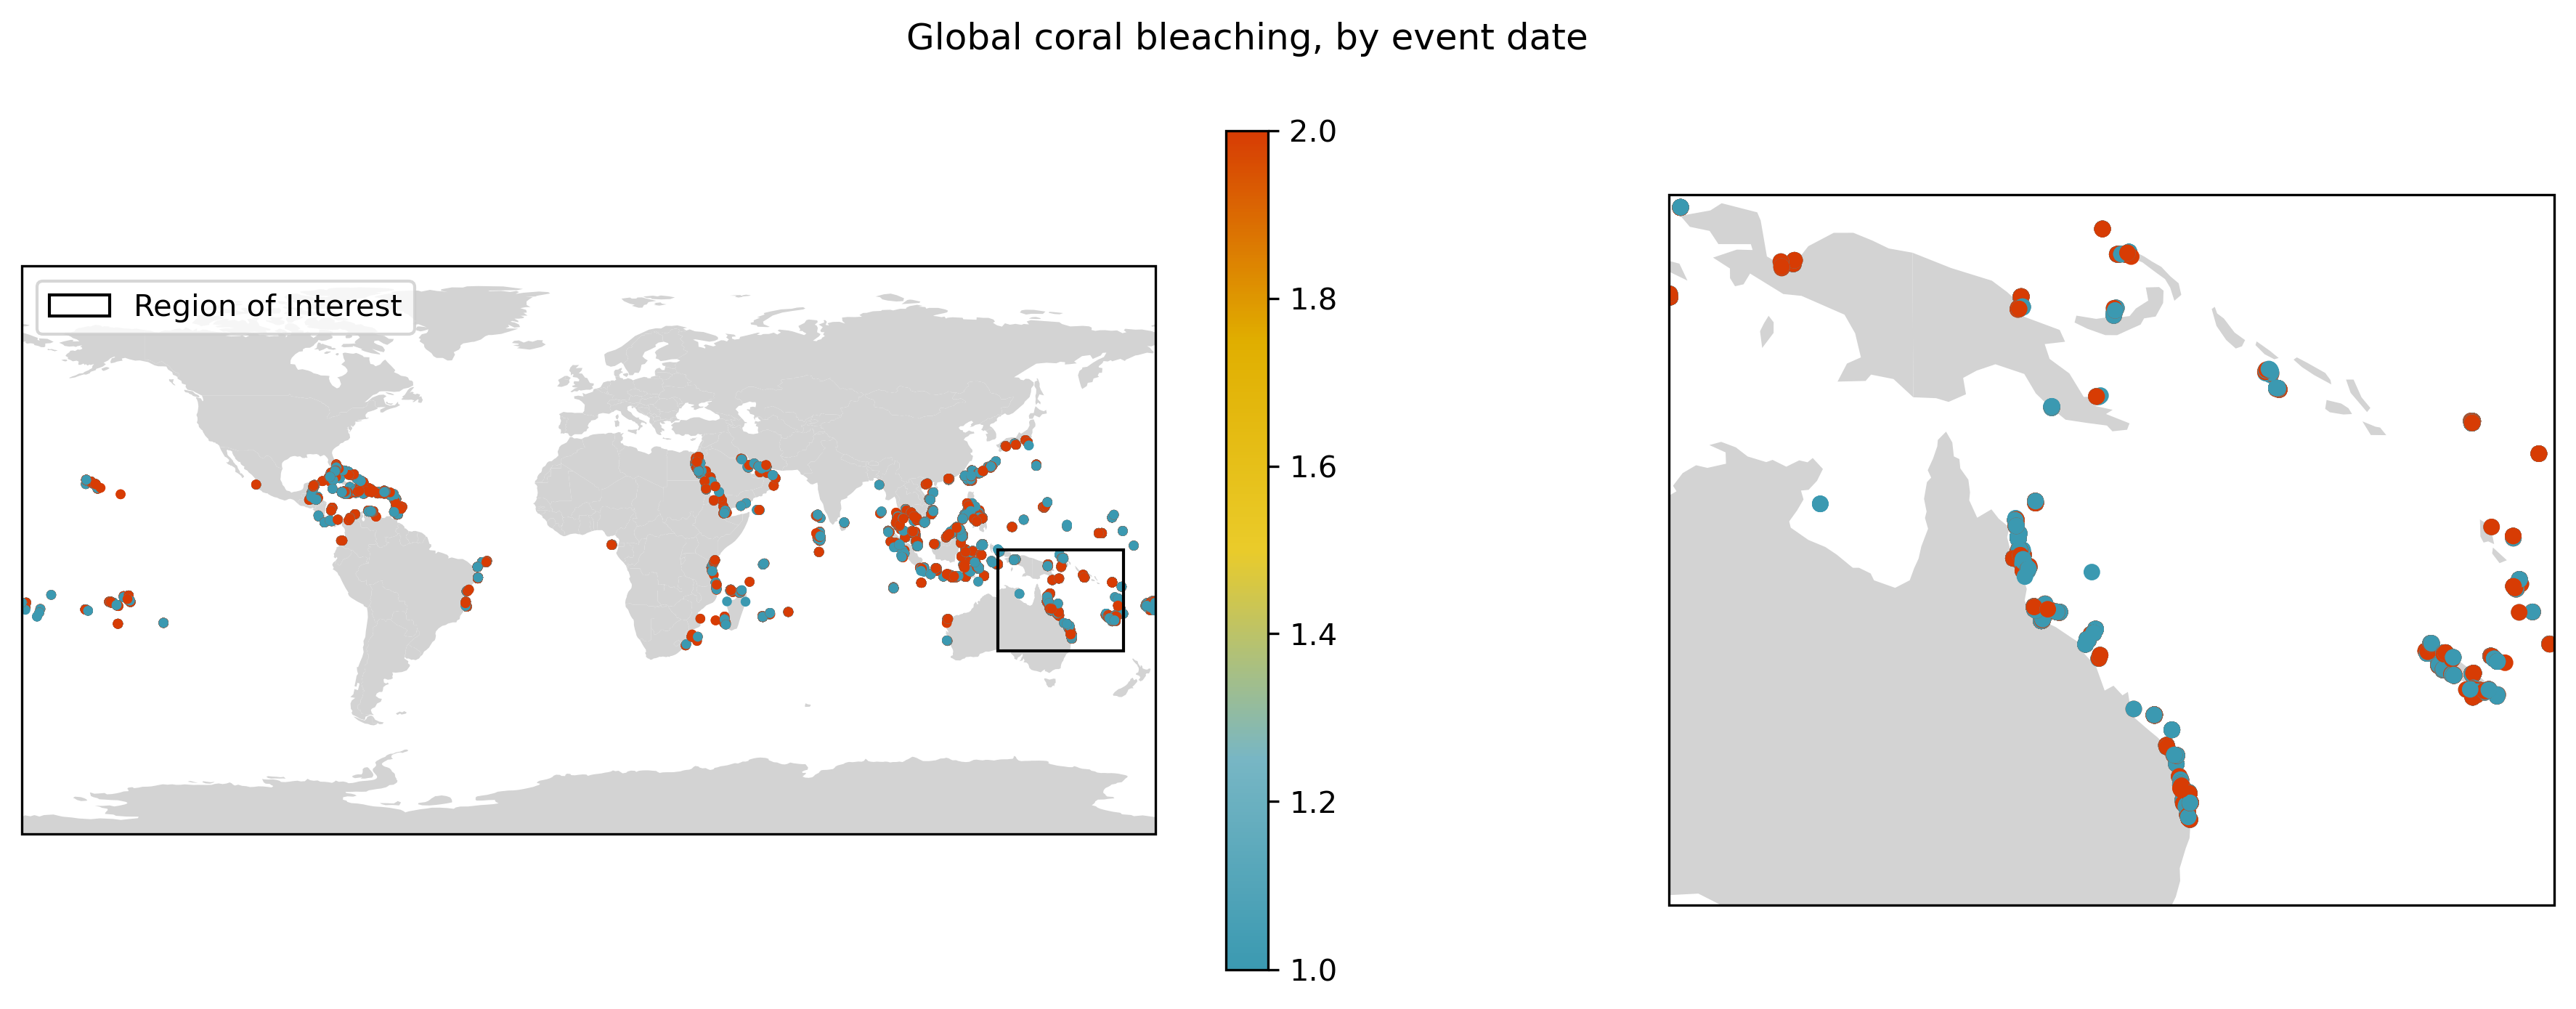

In [114]:
# plot bleaching events by year

from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.patches import Rectangle, Patch
RESOLUTION = 0.01
LATS = [-32, 0]
LONS = [130, 170]

df_all_local = df_all[
    df_all.Longitude_Degrees.between(min(LONS),max(LONS)) & df_all.Latitude_Degrees.between(min(LATS),max(LATS))
    ]

# Create subplots
fig, (ax_global, ax_local) = plt.subplots(
    ncols=2, figsize=(15, 5), subplot_kw=dict(projection=ccrs.PlateCarree()), dpi=300, 
    gridspec_kw={'width_ratios': [1.6, 1]})

# Scatter plot for global and local data
cmap = spatial_plots.get_cbar("seq")

countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
# Plot countries and grid for both axes
for axis in (ax_global, ax_local):
    countries.plot(color="lightgrey", ax=axis)
    axis.grid(alpha=0.5)

im_global = df_all.sort_values(by='Bleaching_Level', ascending=True).plot(
  x="Longitude_Degrees", y="Latitude_Degrees", kind="scatter", c=(df_all['Bleaching_Level']),
  colormap=cmap, title="", ax=ax_global, s=5, colorbar=True)
im_local = df_all_local.sort_values(by='Bleaching_Level', ascending=True).plot(
    x="Longitude_Degrees", y="Latitude_Degrees", kind="scatter", c=(df_all_local['Bleaching_Level']),
    colormap=cmap, title="", ax=ax_local, colorbar=False, alpha=1)

# Add a rectangle to the global axis to show the local area
rect = Rectangle((min(LONS), min(LATS)), max(LONS) - min(LONS), max(LATS) - min(LATS),
                linewidth=1, edgecolor='black', facecolor='none')
ax_global.add_patch(rect)

# Set limits for the local axis
ax_local.set_xlim((min(LONS),max(LONS)))
ax_local.set_ylim((min(LATS),max(LATS)))

# TODO: stop normalisation
# Create a single colorbar using ScalarMappable
# norm = Normalize(vmin=min(df_all['Bleaching_Level']), vmax=max(df_all['Bleaching_Level']))
# sm_global = cm.ScalarMappable(cmap=cmap, norm=norm)

# # Add colorbar (horizontal) below both subplots
# cbar = fig.colorbar(sm_global, ax=[ax_global, ax_local], orientation='horizontal', pad=0.02, aspect=40)

# cbar = fig.colorbar(im_global, ax=[ax_global, ax_local], orientation='horizontal', pad=0.02, aspect=40, 
#     vmin=min(df_all['Bleaching_Level']), vmax=max(df_all['Bleaching_Level']))


# Set title for the colorbar
cbar.set_label('Bleaching_Level')

# Dummy plot for legend on the local axis
legend_rect_dummy = Rectangle((0, 0), 0, 0, linewidth=1, edgecolor='black', facecolor='none', label='Region of Interest')
ax_global.legend(handles=[legend_rect_dummy], loc='upper left')

plt.suptitle("Global coral bleaching, by event date")

plt.show()